In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras

df=pd.read_excel('/content/drive/MyDrive/[텍스트분석] 팀 프로젝트/dataset/article_df_final.xlsx', engine='openpyxl')
X = df['main']
y = df['section']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

# 2. 데이터 전처리
# 텍스트를 숫자 형태로 변환
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 시퀀스 패딩
max_len = 1000  # 시퀀스 길이를 맞추기 위한 최대 길이
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 기사 카테고리를 원-핫 인코딩

from keras.utils import to_categorical
y_train=y_train-100
y_test=y_test-100
# 레이블 데이터를 원-핫 인코딩으로 변환
y_train = to_categorical(y_train,6)
y_test = to_categorical(y_test, 6)

# 3. 모델 구축
model = keras.Sequential()
model.add(keras.layers.Embedding(10000, 64, input_length=max_len))
model.add(keras.layers.Conv1D(128, 5, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(6, activation='softmax'))

# 4. 모델 훈련
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)

# 5. 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# 6. 새로운 기사 분류
def predict_category(news_text):
    # 입력 기사 텍스트를 숫자 형태로 변환
    news_seq = tokenizer.texts_to_sequences([news_text])
    # 시퀀스 패딩
    news_seq = pad_sequences(news_seq, maxlen=max_len)
    # 카테고리 예측
    predicted_prob = model.predict(news_seq)[0]
    predicted_category = np.argmax(predicted_prob)
    return predicted_category

# 새로운 기사 입력
news = "LG에너지솔루션의 4번째 JV 파트너는 현대자동차그룹이었다. 2009년 현대차그룹의 첫 친환경차 아반떼 LPi 하이브리드 배터리 공급으로 시작된 양사의 파트너십이 인도네시아에 이어 미국 JV로 이어졌다."
predicted_category = predict_category(news)
print("\nPredicted Category:", predicted_category+100)
if (predicted_category+100)== 100:
  print("정치")
elif  (predicted_category+100)== 101:
  print("경제")
elif  (predicted_category+100)== 102:
  print("사회")
elif  (predicted_category+100)== 103:
  print("생활/문화")
elif  (predicted_category+100)== 104:
  print("세계")
elif  (predicted_category+100)== 105:
  print("IT/과학")


Epoch 1/10
33/33 [==============================] - 7s 193ms/step - loss: 1.7705 - accuracy: 0.2705
Epoch 2/10
33/33 [==============================] - 9s 263ms/step - loss: 1.5808 - accuracy: 0.6038
Epoch 3/10
33/33 [==============================] - 10s 298ms/step - loss: 1.1326 - accuracy: 0.8695
Epoch 4/10
33/33 [==============================] - 7s 201ms/step - loss: 0.5726 - accuracy: 0.9333
Epoch 5/10
33/33 [==============================] - 8s 247ms/step - loss: 0.2386 - accuracy: 0.9657
Epoch 6/10
33/33 [==============================] - 7s 200ms/step - loss: 0.0874 - accuracy: 0.9905
Epoch 7/10
33/33 [==============================] - 8s 248ms/step - loss: 0.0355 - accuracy: 0.9990
Epoch 8/10
33/33 [==============================] - 7s 195ms/step - loss: 0.0186 - accuracy: 1.0000
Epoch 9/10
33/33 [==============================] - 8s 246ms/step - loss: 0.0120 - accuracy: 1.0000
Epoch 10/10
15/15 [==============================] - 1s 49ms/step - loss: 0.4303 - accuracy: 0.8800

15/15 [==============================] - 1s 79ms/step


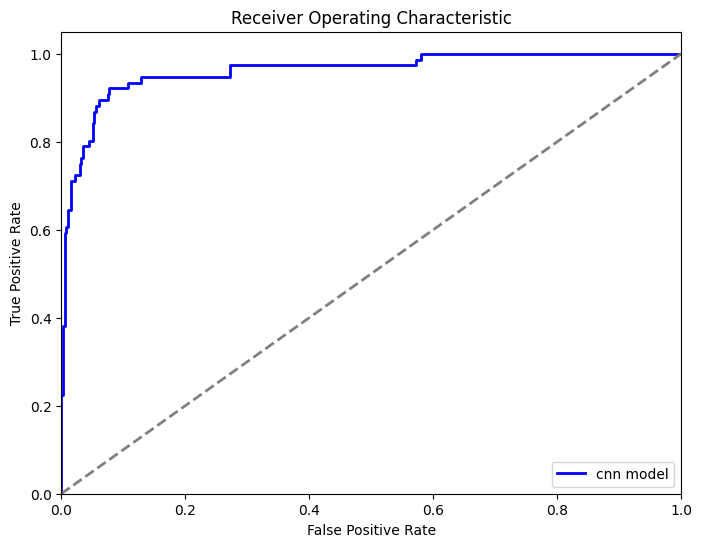

In [ ]:
#roc곡선(다중 클래스라 보류)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test[:, 1], y_pred[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='cnn model' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
#cnn모델 성능향상하기위해 드롭아웃 레이어 추가

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

df = pd.read_excel('/content/drive/MyDrive/[텍스트분석] 팀 프로젝트/dataset/article_df_final.xlsx', engine='openpyxl')
X = df['main']
y = df['section']-100
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, shuffle=True)

# 텍스트를 숫자 형태로 변환
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 시퀀스 패딩
max_len = 1000
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 레이블 데이터를 원-핫 인코딩
from tensorflow.keras.utils import to_categorical
num_classes = len(df['section'].unique())
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 모델 구축
model = Sequential()
model.add(Embedding(10000, 64, input_length=max_len))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # 드롭아웃 추가
model.add(Dense(num_classes, activation='softmax'))

# 모델 컴파일 및 학습
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)



# 6. 새로운 기사 분류
def predict_category(news_text):
    # 입력 기사 텍스트를 숫자 형태로 변환
    news_seq = tokenizer.texts_to_sequences([news_text])
    # 시퀀스 패딩
    news_seq = pad_sequences(news_seq, maxlen=max_len)
    # 카테고리 예측
    predicted_prob = model.predict(news_seq)[0]
    predicted_category = np.argmax(predicted_prob)
    return predicted_category

# 새로운 기사 입력
#news = "LG에너지솔루션의 4번째 JV 파트너는 현대자동차그룹이었다. 2009년 현대차그룹의 첫 친환경차 아반떼 LPi 하이브리드 배터리 공급으로 시작된 양사의 파트너십이 인도네시아에 이어 미국 JV로 이어졌다."
news = 'SK하이닉스가 일반 소비자들을 대상으로 한 휴대용 솔리드스테이트드라이브(SSD) ‘비틀 X31’을 국내 시장에 공개했다고 5일 밝혔다. 비틀 X31은 SK하이닉스의 첫번째 외장형 SSD 제품이다. 황금색 금속 알루미늄 외관에 이름처럼 딱정벌레를 닮은 디자인이 특징이다. 이 제품은 11번가 등 온라인 판매 업체를 통해 지난달 국내 시장에 공개된 후 1차 입고 물량이 하루 만에 완판될 정도로 인기를 끌고 있다. 초당 10기가비트(Gbps)의 동작 속도와 효과적인 발열 관리 성능이 인기 비결로 꼽힌다. SK하이닉스에 따르면 이 제품은 순차 읽기 최대 초당 1050메가바이트(MB/s), 순차 쓰기 최대 초당 1000MB/s의 처리 속도를 구현했다. 이는 1기가바이트(GB) 크기의 파일을 1초 만에 옮길 수 있는 속도다. 특히 발열을 안정적으로 관리하면서 데이터 저장 속도를 최상으로 유지하는 기술이 돋보인다. SK하이닉스 측은 “500GB의 데이터를 평균 900MB/s 이상으로 속도를 유지하면서 9분 이내로 이동할 수 있다”고 강조했다. 알루미늄 외관 케이스를 채택해 방열 효과와 내구성을 확보했다. 내부 기준으로 2m 낙하 테스트를 거쳐 물리적 충격에 대한 내구성을 검증했다. 제품 보증을 3년 간 지원해 소비자 신뢰성 역시 높였다. 한 손에 들어오는 크기와 딱정벌레를 연상시키는 개성있는 디자인 역시 소비자들 사이 인기다. 53g의 초경량, 74x46x14.8밀리미터㎜의 초소형 사이즈로 휴대성을 높였다. 비틀 X31은 IBM PC와 애플의 맥(Mac), 태블릿, 안드로이드 기반 스마트폰, 게임 콘솔 등 다양한 장치와 호환된다. 용량은 512GB, 1테라바이트(TB), 두 가지 종류로 출시됐다. USB 연결 케이블 2종(C-to-C, C-to-A)과 함께 전용 범퍼케이스가 제공된다. 박찬동 SK하이닉스 낸드 마케팅 담당 부사장은 “X31을 시작으로 국내 시장에 이어 해외 시장까지, 포터블 SSD 시장 트렌드를 선도해 갈 것”이라고 말했다.'

predicted_category = predict_category(news)
print("\nPredicted Category:", predicted_category+100)
if (predicted_category+100)== 100:
  print("정치")
elif  (predicted_category+100)== 101:
  print("경제")
elif  (predicted_category+100)== 102:
  print("사회")
elif  (predicted_category+100)== 103:
  print("생활/문화")
elif  (predicted_category+100)== 104:
  print("세계")
elif  (predicted_category+100)== 105:
  print("IT/과학")


Epoch 1/10
33/33 [==============================] - 12s 338ms/step - loss: 1.7849 - accuracy: 0.1838 - val_loss: 1.7606 - val_accuracy: 0.5022
Epoch 2/10
33/33 [==============================] - 8s 243ms/step - loss: 1.6972 - accuracy: 0.4686 - val_loss: 1.6741 - val_accuracy: 0.5867
Epoch 3/10
33/33 [==============================] - 10s 310ms/step - loss: 1.4830 - accuracy: 0.6038 - val_loss: 1.3924 - val_accuracy: 0.7889
Epoch 4/10
33/33 [==============================] - 11s 334ms/step - loss: 1.1115 - accuracy: 0.7410 - val_loss: 1.0343 - val_accuracy: 0.8222
Epoch 5/10
33/33 [==============================] - 8s 252ms/step - loss: 0.7126 - accuracy: 0.8676 - val_loss: 0.7642 - val_accuracy: 0.8356
Epoch 6/10
33/33 [==============================] - 11s 323ms/step - loss: 0.4269 - accuracy: 0.9181 - val_loss: 0.5895 - val_accuracy: 0.8533
Epoch 7/10
33/33 [==============================] - 10s 314ms/step - loss: 0.2518 - accuracy: 0.9552 - val_loss: 0.5181 - val_accuracy: 0.8733
E

Test Loss: 0.46104303002357483
Test Accuracy: 0.8799999952316284
1/1 [==============================] - 0s 82ms/step

Predicted Category: 101
경제
